# SARIMA Models - Lab

## Introduction

In this lesson, we'll reiterate what you learned previously, and talk about **integrated** models (hence ARIMA, which means as much as **integrated** ARMA), and extend to models that can cope with seasonality of time series.

## Objectives

You will be able to: 

* Demonstrate a conceptual understanding of ARIMA modelling components for time-series forecasting
* Pre-process the data to meet ARIMA based forecasting assumptions
* Identify best model parameters using grid search for p,d,q and seasonal p,d,q parameters
* Evaluate the ARIMA model with validation testing
* Predict and visualize future values and calculate confidence level for the predictions 

## ARIMA

Time series provide the opportunity to predict/forecast future values based on previous values. Such analyses can be used to forecast trends in economics, weather, and capacity planning etc. The specific properties of time-series data mean that specialized statistical methods are usually required.

So far, we have seen different techniques to make time series stationary, as well as White Noise, Moving Average, AR, MA and ARMA models. Now recall that your data needs to be detrended (or made **stationary**) before you can go along and use ARMA models. This is because it is easier to add trends and seasonality back in after you modeled your data. Now there are several issues with ARMA:

- ARMA models assume that the detrending already happened
- ARMA neglects that seasonality can happen

Let's summarize what we can observe when having time series in three situations:

1. A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.

2. A nonstationary series with significant dependence among values, but no seasonality. In this case we can use ARMA models after we detrended, or we can use an **integrated** ARMA model that detrends for us.

3. A nonstationary series with significant dependence among values, **and** seasonality. In this case we can use a seasonal arima or SARIMA model.

In this tutorial, we aim to produce reliable forecasts of a given time series by applying one of the most commonly used method for time series forecasting: ARIMA. After that we'll talk about seasonality and how to cope with it. 

One of the methods available in Python to model and predict future points of a time series is known as SARIMAX, which stands for **Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors**. Here, we will primarily focus on the **ARIMA** component, which is used to fit time-series data to better understand and forecast future points in the time series.

## Dataset

For this lab we shall use the dataset that we have seen before - "Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.," which collected CO2 samples from March 1958 to December 2001 (shown in lab1 if time-series). Let's bring in this data and plot as demosntrated earlier. You need to perform following tasks.

1. Import necessary libraries
2. import the CO2 dataset from `statsmodels`
3. Resample the data as monthly groups and take monthly average
4. Fill in the missing values with `Pandas.bfill()`
5. Plot the timeseries and inspect the head of data 

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [20]:
#Load the CO2 dataset from sm.datasets
df = pd.DataFrame.from_records(sm.datasets.co2.load().data)
df['date'] = df.date.apply(lambda x: x.decode('utf-8'))
df['date'] = pd.to_datetime(df.date, format='%Y%m%d')
df.set_index('date',inplace=True)
df.head(20)
# Use 'MS' string to group the data in buckets by start of the month


# Fill in missing values

# Plot the time-series


# 1958-03-01    316.100000
# 1958-04-01    317.200000
# 1958-05-01    317.433333
# 1958-06-01    315.625000
# 1958-07-01    315.625000
# Freq: MS, Name: co2, dtype: float64

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9
1958-05-10,NaN
1958-05-17,317.5
1958-05-24,317.9


In [19]:
CO2_monthly=df['co2'].resample('MS').mean()
CO2_monthly.head()

date
1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [21]:
CO2_monthly.bfill(inplace=True)
CO2_monthly.head(10)

date
1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01    313.425000
1958-11-01    313.425000
1958-12-01    314.700000
Freq: MS, Name: co2, dtype: float64

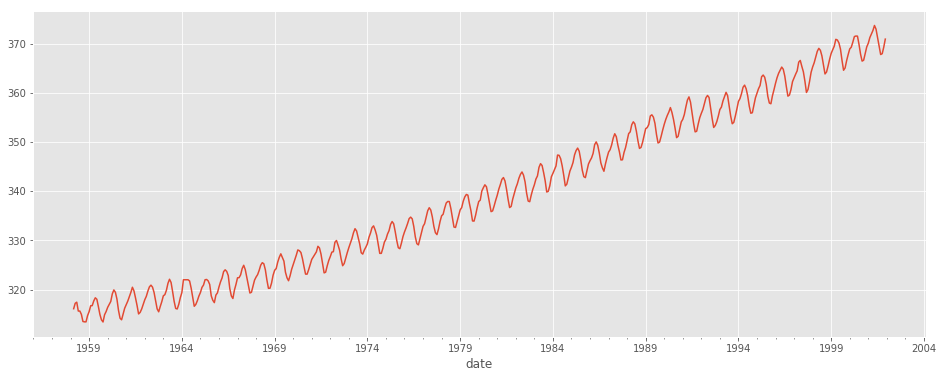

In [22]:
CO2_monthly.plot(figsize=(16,6))

As noted earlier, the time series has spikes reflecting an obvious seasonality pattern, as well as an overall increasing trend.

## The ARIMA Time Series Model

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for **AutoregRessive Integrated Moving Average**. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

Let's have a quick introduction to ARIMA. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

### Number of AR (Auto-Regressive) terms (p): 

`p` is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to rain tomorrow if it has been raining for past 3 days. AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

### Number of Differences (d):

`d` is the **Integrated** component of an ARIMA model. This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation. Intuitively, this would be similar to stating that it is likely to rain tomorrow if the difference in amount of rain in the last *n* days is small. 

### Number of MA (Moving Average) terms (q): 

`q` is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past. MA terms form lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where `e(i)` is the difference between the moving average at ith instant and actual value.

These three distinct integer values, (p, d, q), are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation `ARIMA(p, d, q)`. Together these three parameters account for seasonality, trend, and noise in datasets:

* `(p, d, q)` are the non-seasonal parameters described above.
* `(P, D, Q)` follow the same definition but are applied to the seasonal component of the time series. 
* The term `s` is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

A detailed article on these parameters is available [HERE](https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. In the next section, we will describe how to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model.

## Parameter Selection for the ARIMA Time Series Model


The first step towards fitting an ARIMA model is to find the values of `ARIMA(p,d,q)(P,D,Q)s` that produce the desired output. Selection of these parameters requires domain expertise and time.  We shall first generate small ranges of these parameters and use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the `SARIMAX()` function from the statsmodels module and assess its overall quality. 

`SARIMAX` detailed documentation can be viewed [HERE](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)

Let's begin by generating example combination of parameters that we wish to use.

1. Define p,q and d parameters to take any value from 0/1 using `range()` function. (Note: We can try larger values which can make our model computationally expensive to run, you can try this as an additional experiment)

2. Generate combinations for `(p,d,q)` using `itertools.product`.
3. Similarly, generate seasonal combinations as `(p,d,q)s`. Use s = 12 (constant)
4. Print some example combinations for seasonal ARIMA

In [60]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = list(itertools.product(p,d,q,[12]))


In [61]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

## AIC (Akaike Information Criterion) as Regularization Measure

For evaluating the model, we shall use the AIC (Akaike Information Criterion) value, which is provided by ARIMA models fitted using `statsmodels` library. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection. 

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value. To achieve this, perform following tasks:

1. Initialize an empty list to store results
2. iterate through all the paramaters in pdq with parameters in seasonal pdq (nested loop ) to create a grid
3. Run `SARIMAX` from statsmodels for each iteration. Details can be found [HERE](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html). Set `enforce_stationarity` and `enforce_invertibility` to False. 
4. Get the results in each iteration with `model.fit()` and store the AIC values. 
5. Find the lowest AIC and select parameters for further analysis. 

NOTE: 
* Integrate exception handling with `continue`. 
* An overview of Akaike Information Criterion can be viewed [HERE](http://www.statisticshowto.com/akaikes-information-criterion/)



In [62]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
results=[]
for a in pdq:
    for b in pdqs:
        try:
            model=sm.tsa.statespace.SARIMAX(CO2_monthly,order=a,seasonal_order=b,enforce_stationarity=False,enforce_invertibility=False)
            output=model.fit()
            results.append([a,b,output.aic])
            print(f'ARIMA {a} x {b} : AIC = {output.aic}')
        except:
            continue
            
            
# ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.34362403487
# ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727637512
# ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320024
#     .
#     .
#     .
#     .
# ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:327.9049164493077
# ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:444.1243686483202
# ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:277.78021965631604    

ARIMA (0, 0, 0) x (0, 0, 0, 12) : AIC = 7612.583429881011
ARIMA (0, 0, 0) x (0, 0, 1, 12) : AIC = 6787.343624036742
ARIMA (0, 0, 0) x (0, 0, 2, 12) : AIC = 6027.256393004287
ARIMA (0, 0, 0) x (0, 1, 0, 12) : AIC = 1854.828234141261
ARIMA (0, 0, 0) x (0, 1, 1, 12) : AIC = 1596.7111727641156
ARIMA (0, 0, 0) x (0, 1, 2, 12) : AIC = 1480.791093205136
ARIMA (0, 0, 0) x (0, 2, 0, 12) : AIC = 1414.032574253477
ARIMA (0, 0, 0) x (0, 2, 1, 12) : AIC = 1049.188550967022
ARIMA (0, 0, 0) x (0, 2, 2, 12) : AIC = 1000.6304768410312


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 0, 0, 12) : AIC = 1058.9388921320028
ARIMA (0, 0, 0) x (1, 0, 1, 12) : AIC = 1056.2878498284585
ARIMA (0, 0, 0) x (1, 0, 2, 12) : AIC = 1027.991625884741
ARIMA (0, 0, 0) x (1, 1, 0, 12) : AIC = 1361.6578978072075
ARIMA (0, 0, 0) x (1, 1, 1, 12) : AIC = 1044.7647912934656
ARIMA (0, 0, 0) x (1, 1, 2, 12) : AIC = 998.6335093313829
ARIMA (0, 0, 0) x (1, 2, 0, 12) : AIC = 1236.4167518164884
ARIMA (0, 0, 0) x (1, 2, 1, 12) : AIC = 1036.873199167933
ARIMA (0, 0, 0) x (1, 2, 2, 12) : AIC = 1001.9764502347657
ARIMA (0, 0, 0) x (2, 0, 0, 12) : AIC = 1028.8283750317812


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (2, 0, 1, 12) : AIC = 1029.9002821322872


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (2, 0, 2, 12) : AIC = 1030.9736004005697
ARIMA (0, 0, 0) x (2, 1, 0, 12) : AIC = 1221.32243896506
ARIMA (0, 0, 0) x (2, 1, 1, 12) : AIC = 1005.7343825341011


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (2, 1, 2, 12) : AIC = 998.6952199444786
ARIMA (0, 0, 0) x (2, 2, 0, 12) : AIC = 1092.444040822484
ARIMA (0, 0, 0) x (2, 2, 1, 12) : AIC = 994.7689101037913
ARIMA (0, 0, 0) x (2, 2, 2, 12) : AIC = 994.7413526204632
ARIMA (0, 0, 1) x (0, 0, 0, 12) : AIC = 6881.048755158018
ARIMA (0, 0, 1) x (0, 0, 1, 12) : AIC = 6072.662327703169
ARIMA (0, 0, 1) x (0, 0, 2, 12) : AIC = 5330.667177878079
ARIMA (0, 0, 1) x (0, 1, 0, 12) : AIC = 1379.1941067312878
ARIMA (0, 0, 1) x (0, 1, 1, 12) : AIC = 1241.41747167922
ARIMA (0, 0, 1) x (0, 1, 2, 12) : AIC = 1163.286622137891
ARIMA (0, 0, 1) x (0, 2, 0, 12) : AIC = 1199.9294225421886
ARIMA (0, 0, 1) x (0, 2, 1, 12) : AIC = 804.2386839105322
ARIMA (0, 0, 1) x (0, 2, 2, 12) : AIC = 739.8218330131176


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (1, 0, 0, 12) : AIC = 1084.1085686211736
ARIMA (0, 0, 1) x (1, 0, 1, 12) : AIC = 780.4295322534892


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (1, 0, 2, 12) : AIC = 769.327905499287
ARIMA (0, 0, 1) x (1, 1, 0, 12) : AIC = 1119.5957893617642
ARIMA (0, 0, 1) x (1, 1, 1, 12) : AIC = 807.091298859058
ARIMA (0, 0, 1) x (1, 1, 2, 12) : AIC = 734.9191865183319
ARIMA (0, 0, 1) x (1, 2, 0, 12) : AIC = 1002.3465766372735
ARIMA (0, 0, 1) x (1, 2, 1, 12) : AIC = 775.1608138379647
ARIMA (0, 0, 1) x (1, 2, 2, 12) : AIC = 742.4310488451373
ARIMA (0, 0, 1) x (2, 0, 0, 12) : AIC = 752.6301527942271
ARIMA (0, 0, 1) x (2, 0, 1, 12) : AIC = 750.3651227919083


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (2, 0, 2, 12) : AIC = 1274.3791252174278
ARIMA (0, 0, 1) x (2, 1, 0, 12) : AIC = 979.1135741940984
ARIMA (0, 0, 1) x (2, 1, 1, 12) : AIC = 747.8241572532875
ARIMA (0, 0, 1) x (2, 1, 2, 12) : AIC = 731.3916869379369
ARIMA (0, 0, 1) x (2, 2, 0, 12) : AIC = 859.6391162067232
ARIMA (0, 0, 1) x (2, 2, 1, 12) : AIC = 740.0516588991147
ARIMA (0, 0, 1) x (2, 2, 2, 12) : AIC = 738.9376144247367
ARIMA (0, 0, 2) x (0, 0, 0, 12) : AIC = 6166.721714792952
ARIMA (0, 0, 2) x (0, 0, 1, 12) : AIC = 5401.00827340391


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (0, 0, 2, 12) : AIC = 4788.489745613738
ARIMA (0, 0, 2) x (0, 1, 0, 12) : AIC = 1110.2595962024457
ARIMA (0, 0, 2) x (0, 1, 1, 12) : AIC = 1032.2137257838936
ARIMA (0, 0, 2) x (0, 1, 2, 12) : AIC = 963.6153440599934
ARIMA (0, 0, 2) x (0, 2, 0, 12) : AIC = 1109.3054011131496
ARIMA (0, 0, 2) x (0, 2, 1, 12) : AIC = 687.8114878236595
ARIMA (0, 0, 2) x (0, 2, 2, 12) : AIC = 604.7497090592612
ARIMA (0, 0, 2) x (1, 0, 0, 12) : AIC = 681.6657462205098


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (1, 0, 1, 12) : AIC = 656.8392172777635


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (1, 0, 2, 12) : AIC = 1035.3348672905895
ARIMA (0, 0, 2) x (1, 1, 0, 12) : AIC = 987.4210667007493
ARIMA (0, 0, 2) x (1, 1, 1, 12) : AIC = 700.9035673751074
ARIMA (0, 0, 2) x (1, 1, 2, 12) : AIC = 599.5997867349535
ARIMA (0, 0, 2) x (1, 2, 0, 12) : AIC = 879.7089317389303
ARIMA (0, 0, 2) x (1, 2, 1, 12) : AIC = 644.0566719685474
ARIMA (0, 0, 2) x (1, 2, 2, 12) : AIC = 610.210489987066


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (2, 0, 0, 12) : AIC = 675.5643844026423


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (2, 0, 1, 12) : AIC = 695.4195550033753


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (2, 0, 2, 12) : AIC = 1134.928618407522
ARIMA (0, 0, 2) x (2, 1, 0, 12) : AIC = 846.8373205101572


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (2, 1, 1, 12) : AIC = 621.0275588698739


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 2) x (2, 1, 2, 12) : AIC = 599.0082401414403
ARIMA (0, 0, 2) x (2, 2, 0, 12) : AIC = 749.8519429733142
ARIMA (0, 0, 2) x (2, 2, 1, 12) : AIC = 619.4196127455682
ARIMA (0, 0, 2) x (2, 2, 2, 12) : AIC = 616.2793865422962
ARIMA (0, 1, 0) x (0, 0, 0, 12) : AIC = 1675.8086923024293
ARIMA (0, 1, 0) x (0, 0, 1, 12) : AIC = 1240.2211199194057
ARIMA (0, 1, 0) x (0, 0, 2, 12) : AIC = 1009.3810751747551
ARIMA (0, 1, 0) x (0, 1, 0, 12) : AIC = 633.4425586468699
ARIMA (0, 1, 0) x (0, 1, 1, 12) : AIC = 337.7938545681309
ARIMA (0, 1, 0) x (0, 1, 2, 12) : AIC = 315.37831667900605
ARIMA (0, 1, 0) x (0, 2, 0, 12) : AIC = 1129.234151960986
ARIMA (0, 1, 0) x (0, 2, 1, 12) : AIC = 632.1481086001611
ARIMA (0, 1, 0) x (0, 2, 2, 12) : AIC = 395.91565028575957
ARIMA (0, 1, 0) x (1, 0, 0, 12) : AIC = 619.9501759055394
ARIMA (0, 1, 0) x (1, 0, 1, 12) : AIC = 376.9283759285899
ARIMA (0, 1, 0) x (1, 0, 2, 12) : AIC = 317.3733059247889
ARIMA (0, 1, 0) x (1, 1, 0, 12) : AIC = 478.3296906672489
ARIMA (0,

C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (1, 0, 2, 12) : AIC = 276.44651628693686
ARIMA (0, 1, 2) x (1, 1, 0, 12) : AIC = 431.9316622042487
ARIMA (0, 1, 2) x (1, 1, 1, 12) : AIC = 279.8741261085918
ARIMA (0, 1, 2) x (1, 1, 2, 12) : AIC = 274.4251094466669
ARIMA (0, 1, 2) x (1, 2, 0, 12) : AIC = 803.806950858669
ARIMA (0, 1, 2) x (1, 2, 1, 12) : AIC = 471.45445279334217
ARIMA (0, 1, 2) x (1, 2, 2, 12) : AIC = 328.0950549851536
ARIMA (0, 1, 2) x (2, 0, 0, 12) : AIC = 432.51111827262514


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 0, 1, 12) : AIC = 276.9423060808631


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 0, 2, 12) : AIC = 276.9244961752908
ARIMA (0, 1, 2) x (2, 1, 0, 12) : AIC = 357.72149942212616
ARIMA (0, 1, 2) x (2, 1, 1, 12) : AIC = 280.968640606059
ARIMA (0, 1, 2) x (2, 1, 2, 12) : AIC = 276.9930099808632
ARIMA (0, 1, 2) x (2, 2, 0, 12) : AIC = 646.9466850059074
ARIMA (0, 1, 2) x (2, 2, 1, 12) : AIC = 406.42020684773536
ARIMA (0, 1, 2) x (2, 2, 2, 12) : AIC = 353.83377862253985
ARIMA (0, 2, 0) x (0, 0, 0, 12) : AIC = 1404.245593671727
ARIMA (0, 2, 0) x (0, 0, 1, 12) : AIC = 1172.0800568132736
ARIMA (0, 2, 0) x (0, 0, 2, 12) : AIC = 1070.1347347289088
ARIMA (0, 2, 0) x (0, 1, 0, 12) : AIC = 1103.0126459151052
ARIMA (0, 2, 0) x (0, 1, 1, 12) : AIC = 783.0867945114132
ARIMA (0, 2, 0) x (0, 1, 2, 12) : AIC = 758.267152010395
ARIMA (0, 2, 0) x (0, 2, 0, 12) : AIC = 1582.1830883517732
ARIMA (0, 2, 0) x (0, 2, 1, 12) : AIC = 1076.0129314106978
ARIMA (0, 2, 0) x (0, 2, 2, 12) : AIC = 828.6484943051435
ARIMA (0, 2, 0) x (1, 0, 0, 12) : AIC = 1021.1171007352982
ARIMA (

C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ARIMA (0, 2, 0) x (2, 0, 1, 12) : AIC = 782.1685417043182
ARIMA (0, 2, 0) x (2, 0, 2, 12) : AIC = 774.7409349717475
ARIMA (0, 2, 0) x (2, 1, 0, 12) : AIC = 877.6214910982068
ARIMA (0, 2, 0) x (2, 1, 1, 12) : AIC = 762.9887384933529
ARIMA (0, 2, 0) x (2, 1, 2, 12) : AIC = 759.6343686399583
ARIMA (0, 2, 0) x (2, 2, 0, 12) : AIC = 1139.626956515256
ARIMA (0, 2, 0) x (2, 2, 1, 12) : AIC = 914.1974015651975
ARIMA (0, 2, 0) x (2, 2, 2, 12) : AIC = 842.701555132583
ARIMA (0, 2, 1) x (0, 0, 0, 12) : AIC = 1370.564120901827
ARIMA (0, 2, 1) x (0, 0, 1, 12) : AIC = 1172.1578071433269
ARIMA (0, 2, 1) x (0, 0, 2, 12) : AIC = 1047.0450650362652
ARIMA (0, 2, 1) x (0, 1, 0, 12) : AIC = 633.0762519380883
ARIMA (0, 2, 1) x (0, 1, 1, 12) : AIC = 346.01905451635946
ARIMA (0, 2, 1) x (0, 1, 2, 12) : AIC = 323.0556620134535
ARIMA (0, 2, 1) x (0, 2, 0, 12) : AIC = 1129.4727941992262
ARIMA (0, 2, 1) x (0, 2, 1, 12) : AIC = 640.6715363297542
ARIMA (0, 2, 1) x (0, 2, 2, 12) : AIC = 405.486590002276
ARIMA (0, 2

C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (2, 0, 2, 12) : AIC = 288.38661523273294
ARIMA (0, 2, 2) x (2, 1, 0, 12) : AIC = 369.3170060909972
ARIMA (0, 2, 2) x (2, 1, 1, 12) : AIC = 294.29227892096526
ARIMA (0, 2, 2) x (2, 1, 2, 12) : AIC = 288.22689599197946
ARIMA (0, 2, 2) x (2, 2, 0, 12) : AIC = 656.9921368453389
ARIMA (0, 2, 2) x (2, 2, 1, 12) : AIC = 422.8158782515736
ARIMA (0, 2, 2) x (2, 2, 2, 12) : AIC = 371.0648931704804
ARIMA (1, 0, 0) x (0, 0, 0, 12) : AIC = 1676.8881767362054


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 0, 1, 12) : AIC = 1241.9354689077231


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 0, 2, 12) : AIC = 1167.7380063346145
ARIMA (1, 0, 0) x (0, 1, 0, 12) : AIC = 624.2602350563734
ARIMA (1, 0, 0) x (0, 1, 1, 12) : AIC = 341.28966148164375
ARIMA (1, 0, 0) x (0, 1, 2, 12) : AIC = 317.7579980370775
ARIMA (1, 0, 0) x (0, 2, 0, 12) : AIC = 1056.6362762702188
ARIMA (1, 0, 0) x (0, 2, 1, 12) : AIC = 586.5029302278969
ARIMA (1, 0, 0) x (0, 2, 2, 12) : AIC = 393.2092447927021
ARIMA (1, 0, 0) x (1, 0, 0, 12) : AIC = 579.3897229132237


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (1, 0, 1, 12) : AIC = 370.59200702735257
ARIMA (1, 0, 0) x (1, 0, 2, 12) : AIC = 311.5389430928642
ARIMA (1, 0, 0) x (1, 1, 0, 12) : AIC = 476.0500429124218
ARIMA (1, 0, 0) x (1, 1, 1, 12) : AIC = 329.58449918088866
ARIMA (1, 0, 0) x (1, 1, 2, 12) : AIC = 317.6868858322184
ARIMA (1, 0, 0) x (1, 2, 0, 12) : AIC = 788.5235212962984
ARIMA (1, 0, 0) x (1, 2, 1, 12) : AIC = 492.7659256882232
ARIMA (1, 0, 0) x (1, 2, 2, 12) : AIC = 377.02204185832136
ARIMA (1, 0, 0) x (2, 0, 0, 12) : AIC = 444.61409278572944
ARIMA (1, 0, 0) x (2, 0, 1, 12) : AIC = 313.31128966242113


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (2, 0, 2, 12) : AIC = 312.00218090065596
ARIMA (1, 0, 0) x (2, 1, 0, 12) : AIC = 416.41269118064133
ARIMA (1, 0, 0) x (2, 1, 1, 12) : AIC = 320.26556499890984
ARIMA (1, 0, 0) x (2, 1, 2, 12) : AIC = 322.49830117357186
ARIMA (1, 0, 0) x (2, 2, 0, 12) : AIC = 645.3528041798618
ARIMA (1, 0, 0) x (2, 2, 1, 12) : AIC = 441.42328476912695
ARIMA (1, 0, 0) x (2, 2, 2, 12) : AIC = 403.2414719079663
ARIMA (1, 0, 1) x (0, 0, 0, 12) : AIC = 1372.6085881757353
ARIMA (1, 0, 1) x (0, 0, 1, 12) : AIC = 1199.4888161832912


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 0, 2, 12) : AIC = 1064.486288839951
ARIMA (1, 0, 1) x (0, 1, 0, 12) : AIC = 586.4485733402275
ARIMA (1, 0, 1) x (0, 1, 1, 12) : AIC = 305.62738363981595
ARIMA (1, 0, 1) x (0, 1, 2, 12) : AIC = 276.604065423266
ARIMA (1, 0, 1) x (0, 2, 0, 12) : AIC = 1048.7290115198887
ARIMA (1, 0, 1) x (0, 2, 1, 12) : AIC = 570.4263048151265
ARIMA (1, 0, 1) x (0, 2, 2, 12) : AIC = 356.4813062047033


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 0, 12) : AIC = 587.1600566763905
ARIMA (1, 0, 1) x (1, 0, 1, 12) : AIC = 398.2819005841991


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 2, 12) : AIC = 363.8334047451474
ARIMA (1, 0, 1) x (1, 1, 0, 12) : AIC = 433.5469464368633
ARIMA (1, 0, 1) x (1, 1, 1, 12) : AIC = 285.7651697087495
ARIMA (1, 0, 1) x (1, 1, 2, 12) : AIC = 276.9661926717313
ARIMA (1, 0, 1) x (1, 2, 0, 12) : AIC = 775.0363308127481
ARIMA (1, 0, 1) x (1, 2, 1, 12) : AIC = 463.8858234681884
ARIMA (1, 0, 1) x (1, 2, 2, 12) : AIC = 334.033051782137


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (2, 0, 0, 12) : AIC = 491.69400020086715
ARIMA (1, 0, 1) x (2, 0, 1, 12) : AIC = 385.50605402228155


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (2, 0, 2, 12) : AIC = 434.3187284940081
ARIMA (1, 0, 1) x (2, 1, 0, 12) : AIC = 361.4280408255878
ARIMA (1, 0, 1) x (2, 1, 1, 12) : AIC = 283.9810983843446
ARIMA (1, 0, 1) x (2, 1, 2, 12) : AIC = 280.25176788334284
ARIMA (1, 0, 1) x (2, 2, 0, 12) : AIC = 626.898273440368
ARIMA (1, 0, 1) x (2, 2, 1, 12) : AIC = 401.5614117528321
ARIMA (1, 0, 1) x (2, 2, 2, 12) : AIC = 357.8298539991539
ARIMA (1, 0, 2) x (0, 0, 0, 12) : AIC = 1241.827656190278


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (0, 0, 1, 12) : AIC = 1054.9736397526185
ARIMA (1, 0, 2) x (0, 0, 2, 12) : AIC = 1007.2278588316102
ARIMA (1, 0, 2) x (0, 1, 0, 12) : AIC = 581.9154274611859


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (0, 1, 1, 12) : AIC = 300.71041915163573
ARIMA (1, 0, 2) x (0, 1, 2, 12) : AIC = 274.53648467436597
ARIMA (1, 0, 2) x (0, 2, 0, 12) : AIC = 1049.4459151084523
ARIMA (1, 0, 2) x (0, 2, 1, 12) : AIC = 570.3872894725994
ARIMA (1, 0, 2) x (0, 2, 2, 12) : AIC = 348.59398203979396
ARIMA (1, 0, 2) x (1, 0, 0, 12) : AIC = 581.6873897344855


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (1, 0, 1, 12) : AIC = 327.4999135994951
ARIMA (1, 0, 2) x (1, 0, 2, 12) : AIC = 271.12986221689846
ARIMA (1, 0, 2) x (1, 1, 0, 12) : AIC = 432.70193103335805
ARIMA (1, 0, 2) x (1, 1, 1, 12) : AIC = 282.9994155876477


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (1, 1, 2, 12) : AIC = 275.3596698818508
ARIMA (1, 0, 2) x (1, 2, 0, 12) : AIC = 776.8185161873275
ARIMA (1, 0, 2) x (1, 2, 1, 12) : AIC = 464.1248129577902


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (1, 2, 2, 12) : AIC = 328.9852380935106
ARIMA (1, 0, 2) x (2, 0, 0, 12) : AIC = 422.01331089060596


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (2, 0, 1, 12) : AIC = 279.33175855984064


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (2, 0, 2, 12) : AIC = 281.3061453031219
ARIMA (1, 0, 2) x (2, 1, 0, 12) : AIC = 359.3872748080272


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (2, 1, 1, 12) : AIC = 281.5344456195418


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (2, 1, 2, 12) : AIC = 278.13934487515917
ARIMA (1, 0, 2) x (2, 2, 0, 12) : AIC = 628.3031305981797
ARIMA (1, 0, 2) x (2, 2, 1, 12) : AIC = 400.8615483344345
ARIMA (1, 0, 2) x (2, 2, 2, 12) : AIC = 352.9951111847049
ARIMA (1, 1, 0) x (0, 0, 0, 12) : AIC = 1324.311112732457
ARIMA (1, 1, 0) x (0, 0, 1, 12) : AIC = 1060.9351914433164


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 0, 2, 12) : AIC = 928.402579967262
ARIMA (1, 1, 0) x (0, 1, 0, 12) : AIC = 600.7412682874252
ARIMA (1, 1, 0) x (0, 1, 1, 12) : AIC = 312.1329632361338
ARIMA (1, 1, 0) x (0, 1, 2, 12) : AIC = 283.61066816148275
ARIMA (1, 1, 0) x (0, 2, 0, 12) : AIC = 1100.753765041099


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 2, 1, 12) : AIC = 604.0828462290715
ARIMA (1, 1, 0) x (0, 2, 2, 12) : AIC = 368.85441997160933
ARIMA (1, 1, 0) x (1, 0, 0, 12) : AIC = 593.6637754853627
ARIMA (1, 1, 0) x (1, 0, 1, 12) : AIC = 349.20914649282884
ARIMA (1, 1, 0) x (1, 0, 2, 12) : AIC = 284.02369384321383
ARIMA (1, 1, 0) x (1, 1, 0, 12) : AIC = 440.1375884358338
ARIMA (1, 1, 0) x (1, 1, 1, 12) : AIC = 293.7426222758842
ARIMA (1, 1, 0) x (1, 1, 2, 12) : AIC = 284.40487899669625
ARIMA (1, 1, 0) x (1, 2, 0, 12) : AIC = 805.7976970397267
ARIMA (1, 1, 0) x (1, 2, 1, 12) : AIC = 485.8940090747662
ARIMA (1, 1, 0) x (1, 2, 2, 12) : AIC = 351.4554812299004
ARIMA (1, 1, 0) x (2, 0, 0, 12) : AIC = 440.0550744317117
ARIMA (1, 1, 0) x (2, 0, 1, 12) : AIC = 284.9458625897722
ARIMA (1, 1, 0) x (2, 0, 2, 12) : AIC = 286.5233472615665
ARIMA (1, 1, 0) x (2, 1, 0, 12) : AIC = 374.9066287308649
ARIMA (1, 1, 0) x (2, 1, 1, 12) : AIC = 289.9107329346728
ARIMA (1, 1, 0) x (2, 1, 2, 12) : AIC = 288.80059622667716
ARIMA (1,

C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (1, 2, 2, 12) : AIC = 327.03271880806903
ARIMA (1, 1, 1) x (2, 0, 0, 12) : AIC = 428.3034417320458


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (2, 0, 1, 12) : AIC = 274.9013178563433


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (2, 0, 2, 12) : AIC = 275.0548136704289
ARIMA (1, 1, 1) x (2, 1, 0, 12) : AIC = 356.77336569933004
ARIMA (1, 1, 1) x (2, 1, 1, 12) : AIC = 277.07242189585173
ARIMA (1, 1, 1) x (2, 1, 2, 12) : AIC = 275.67449480142506
ARIMA (1, 1, 1) x (2, 2, 0, 12) : AIC = 645.7669566053742
ARIMA (1, 1, 1) x (2, 2, 1, 12) : AIC = 405.56027923709695
ARIMA (1, 1, 1) x (2, 2, 2, 12) : AIC = 353.8863184881815
ARIMA (1, 1, 2) x (0, 0, 0, 12) : AIC = 1210.6092459546476
ARIMA (1, 1, 2) x (0, 0, 1, 12) : AIC = 1020.7360934362648
ARIMA (1, 1, 2) x (0, 0, 2, 12) : AIC = 902.452178734575
ARIMA (1, 1, 2) x (0, 1, 0, 12) : AIC = 568.8958761397042
ARIMA (1, 1, 2) x (0, 1, 1, 12) : AIC = 295.7408859195101
ARIMA (1, 1, 2) x (0, 1, 2, 12) : AIC = 272.94034352778533
ARIMA (1, 1, 2) x (0, 2, 0, 12) : AIC = 1078.7156663947262
ARIMA (1, 1, 2) x (0, 2, 1, 12) : AIC = 584.8792757005325
ARIMA (1, 1, 2) x (0, 2, 2, 12) : AIC = 347.84553915725746
ARIMA (1, 1, 2) x (1, 0, 0, 12) : AIC = 578.7787268141152
ARIMA 

C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (1, 0, 2, 12) : AIC = 276.29346291041065
ARIMA (1, 1, 2) x (1, 1, 0, 12) : AIC = 430.2996801493606
ARIMA (1, 1, 2) x (1, 1, 1, 12) : AIC = 278.98642425679043
ARIMA (1, 1, 2) x (1, 1, 2, 12) : AIC = 273.6242806853017
ARIMA (1, 1, 2) x (1, 2, 0, 12) : AIC = 801.084772883034
ARIMA (1, 1, 2) x (1, 2, 1, 12) : AIC = 471.87924158054227


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (1, 2, 2, 12) : AIC = 328.6339090045371
ARIMA (1, 1, 2) x (2, 0, 0, 12) : AIC = 430.2799558395888
ARIMA (1, 1, 2) x (2, 0, 1, 12) : AIC = 276.7385347573221


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 0, 2, 12) : AIC = 277.7502497646021
ARIMA (1, 1, 2) x (2, 1, 0, 12) : AIC = 358.7597033113239
ARIMA (1, 1, 2) x (2, 1, 1, 12) : AIC = 278.82677454468285
ARIMA (1, 1, 2) x (2, 1, 2, 12) : AIC = 277.3139303426537
ARIMA (1, 1, 2) x (2, 2, 0, 12) : AIC = 647.7667224498617
ARIMA (1, 1, 2) x (2, 2, 1, 12) : AIC = 407.5417843765739


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 2, 2, 12) : AIC = 354.4675367242689
ARIMA (1, 2, 0) x (0, 0, 0, 12) : AIC = 1374.845379561723
ARIMA (1, 2, 0) x (0, 0, 1, 12) : AIC = 1174.0210238096033


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 0) x (0, 0, 2, 12) : AIC = 1051.843496188873
ARIMA (1, 2, 0) x (0, 1, 0, 12) : AIC = 892.6899020786598


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 0) x (0, 1, 1, 12) : AIC = 589.62466846808
ARIMA (1, 2, 0) x (0, 1, 2, 12) : AIC = 558.3558066571366
ARIMA (1, 2, 0) x (0, 2, 0, 12) : AIC = 1383.3494631592512
ARIMA (1, 2, 0) x (0, 2, 1, 12) : AIC = 878.1183122675072
ARIMA (1, 2, 0) x (0, 2, 2, 12) : AIC = 643.1027891715369
ARIMA (1, 2, 0) x (1, 0, 0, 12) : AIC = 864.1715035794582
ARIMA (1, 2, 0) x (1, 0, 1, 12) : AIC = 637.9176265023008
ARIMA (1, 2, 0) x (1, 0, 2, 12) : AIC = 566.0495554641327
ARIMA (1, 2, 0) x (1, 1, 0, 12) : AIC = 720.657658584711
ARIMA (1, 2, 0) x (1, 1, 1, 12) : AIC = 572.1786410653989
ARIMA (1, 2, 0) x (1, 1, 2, 12) : AIC = 557.9456226267483
ARIMA (1, 2, 0) x (1, 2, 0, 12) : AIC = 1066.4771409786217
ARIMA (1, 2, 0) x (1, 2, 1, 12) : AIC = 759.8350895410265
ARIMA (1, 2, 0) x (1, 2, 2, 12) : AIC = 622.4671793741848
ARIMA (1, 2, 0) x (2, 0, 0, 12) : AIC = 713.8433486338922
ARIMA (1, 2, 0) x (2, 0, 1, 12) : AIC = 567.5766431663195
ARIMA (1, 2, 0) x (2, 0, 2, 12) : AIC = 565.5650554219877
ARIMA (1, 2, 0)

C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (2, 0, 2, 12) : AIC = 297.1062231680038
ARIMA (1, 2, 1) x (2, 1, 0, 12) : AIC = 381.8852761912749
ARIMA (1, 2, 1) x (2, 1, 1, 12) : AIC = 300.99640915683574
ARIMA (1, 2, 1) x (2, 1, 2, 12) : AIC = 298.187128478667
ARIMA (1, 2, 1) x (2, 2, 0, 12) : AIC = 665.2794055176491
ARIMA (1, 2, 1) x (2, 2, 1, 12) : AIC = 434.7776501767952
ARIMA (1, 2, 1) x (2, 2, 2, 12) : AIC = 384.6616136658267
ARIMA (1, 2, 2) x (0, 0, 0, 12) : AIC = 1256.703496891303
ARIMA (1, 2, 2) x (0, 0, 1, 12) : AIC = 1052.9120795556396
ARIMA (1, 2, 2) x (0, 0, 2, 12) : AIC = 928.6221060717219
ARIMA (1, 2, 2) x (0, 1, 0, 12) : AIC = 569.7778080471178
ARIMA (1, 2, 2) x (0, 1, 1, 12) : AIC = 299.5159716392916
ARIMA (1, 2, 2) x (0, 1, 2, 12) : AIC = 280.76393598385084
ARIMA (1, 2, 2) x (0, 2, 0, 12) : AIC = 1080.4628249745465
ARIMA (1, 2, 2) x (0, 2, 1, 12) : AIC = 595.3500280657463
ARIMA (1, 2, 2) x (0, 2, 2, 12) : AIC = 354.8325610258685
ARIMA (1, 2, 2) x (1, 0, 0, 12) : AIC = 586.9085765063157


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 0, 1, 12) : AIC = 320.4846613155662


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 0, 2, 12) : AIC = 284.84318087449833
ARIMA (1, 2, 2) x (1, 1, 0, 12) : AIC = 438.95373840852915
ARIMA (1, 2, 2) x (1, 1, 1, 12) : AIC = 286.33632146393535


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 1, 2, 12) : AIC = 281.23942145838123
ARIMA (1, 2, 2) x (1, 2, 0, 12) : AIC = 808.7812100743406
ARIMA (1, 2, 2) x (1, 2, 1, 12) : AIC = 484.876722866348


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 2, 2, 12) : AIC = 338.7742821623898
ARIMA (1, 2, 2) x (2, 0, 0, 12) : AIC = 443.4461210221676


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 0, 1, 12) : AIC = 287.84072863429714


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 0, 2, 12) : AIC = 288.9834507300735
ARIMA (1, 2, 2) x (2, 1, 0, 12) : AIC = 364.4393576078204


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 1, 1, 12) : AIC = 291.48211323789684


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 1, 2, 12) : AIC = 299.751074387995
ARIMA (1, 2, 2) x (2, 2, 0, 12) : AIC = 653.001593279901
ARIMA (1, 2, 2) x (2, 2, 1, 12) : AIC = 417.5769759603421
ARIMA (1, 2, 2) x (2, 2, 2, 12) : AIC = 367.2342987790113
ARIMA (2, 0, 0) x (0, 0, 0, 12) : AIC = 1325.7204635594803
ARIMA (2, 0, 0) x (0, 0, 1, 12) : AIC = 1152.3446995234062
ARIMA (2, 0, 0) x (0, 0, 2, 12) : AIC = 1030.0873305383639
ARIMA (2, 0, 0) x (0, 1, 0, 12) : AIC = 595.9688070910082
ARIMA (2, 0, 0) x (0, 1, 1, 12) : AIC = 316.77937813265555
ARIMA (2, 0, 0) x (0, 1, 2, 12) : AIC = 285.1024577063879
ARIMA (2, 0, 0) x (0, 2, 0, 12) : AIC = 1049.1933857267372

C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ARIMA (2, 0, 0) x (0, 2, 1, 12) : AIC = 575.7933010497904
ARIMA (2, 0, 0) x (0, 2, 2, 12) : AIC = 367.4293896434683
ARIMA (2, 0, 0) x (1, 0, 0, 12) : AIC = 595.643165486307


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 0) x (1, 0, 1, 12) : AIC = 344.14477432179837


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 0) x (1, 0, 2, 12) : AIC = 282.98140677599906
ARIMA (2, 0, 0) x (1, 1, 0, 12) : AIC = 439.7211374967153
ARIMA (2, 0, 0) x (1, 1, 1, 12) : AIC = 293.8643520495094
ARIMA (2, 0, 0) x (1, 1, 2, 12) : AIC = 286.7826588835361
ARIMA (2, 0, 0) x (1, 2, 0, 12) : AIC = 771.8822570827351
ARIMA (2, 0, 0) x (1, 2, 1, 12) : AIC = 467.234917856353
ARIMA (2, 0, 0) x (1, 2, 2, 12) : AIC = 350.38615576183435


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 0) x (2, 0, 0, 12) : AIC = 422.1690559789437


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 0) x (2, 0, 1, 12) : AIC = 293.33938770167214


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 0) x (2, 0, 2, 12) : AIC = 284.18675955954177
ARIMA (2, 0, 0) x (2, 1, 0, 12) : AIC = 375.93369754172375
ARIMA (2, 0, 0) x (2, 1, 1, 12) : AIC = 291.20445983381967
ARIMA (2, 0, 0) x (2, 1, 2, 12) : AIC = 287.93500685215525
ARIMA (2, 0, 0) x (2, 2, 0, 12) : AIC = 629.0748748370906
ARIMA (2, 0, 0) x (2, 2, 1, 12) : AIC = 411.21223045199906


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 0) x (2, 2, 2, 12) : AIC = 346.3130726707953
ARIMA (2, 0, 1) x (0, 0, 0, 12) : AIC = 1265.556037735661


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (0, 0, 1, 12) : AIC = 1091.6595076521858
ARIMA (2, 0, 1) x (0, 0, 2, 12) : AIC = 1029.697207381122
ARIMA (2, 0, 1) x (0, 1, 0, 12) : AIC = 581.3805398516471


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (0, 1, 1, 12) : AIC = 297.63076834093124
ARIMA (2, 0, 1) x (0, 1, 2, 12) : AIC = 272.5056230526905
ARIMA (2, 0, 1) x (0, 2, 0, 12) : AIC = 1050.4688988442517
ARIMA (2, 0, 1) x (0, 2, 1, 12) : AIC = 570.7268402465043
ARIMA (2, 0, 1) x (0, 2, 2, 12) : AIC = 349.5643205301641
ARIMA (2, 0, 1) x (1, 0, 0, 12) : AIC = 578.7673698413993
ARIMA (2, 0, 1) x (1, 0, 1, 12) : AIC = 330.8760529699794


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (1, 0, 2, 12) : AIC = 271.9606088102587
ARIMA (2, 0, 1) x (1, 1, 0, 12) : AIC = 429.47989298354724


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (1, 1, 1, 12) : AIC = 280.67614474922345


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (1, 1, 2, 12) : AIC = 273.49919916752583
ARIMA (2, 0, 1) x (1, 2, 0, 12) : AIC = 773.4685228622675
ARIMA (2, 0, 1) x (1, 2, 1, 12) : AIC = 464.5225651201765


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (1, 2, 2, 12) : AIC = 330.97051824712577
ARIMA (2, 0, 1) x (2, 0, 0, 12) : AIC = 418.9573084563062


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (2, 0, 1, 12) : AIC = 274.3341908221889


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (2, 0, 2, 12) : AIC = 275.40017003733635
ARIMA (2, 0, 1) x (2, 1, 0, 12) : AIC = 358.4726917244128


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (2, 1, 1, 12) : AIC = 278.8730942728349


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (2, 1, 2, 12) : AIC = 276.5029122501071
ARIMA (2, 0, 1) x (2, 2, 0, 12) : AIC = 627.7327736421579
ARIMA (2, 0, 1) x (2, 2, 1, 12) : AIC = 400.200153817314


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 1) x (2, 2, 2, 12) : AIC = 354.15028932183156


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (0, 0, 0, 12) : AIC = 1217.8923558329623


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (0, 0, 1, 12) : AIC = 1071.0173449854567
ARIMA (2, 0, 2) x (0, 0, 2, 12) : AIC = 996.6207220104693
ARIMA (2, 0, 2) x (0, 1, 0, 12) : AIC = 582.4294129648583


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (0, 1, 1, 12) : AIC = 298.77003727689254


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (0, 1, 2, 12) : AIC = 273.66405029795897
ARIMA (2, 0, 2) x (0, 2, 0, 12) : AIC = 1051.4785912869686
ARIMA (2, 0, 2) x (0, 2, 1, 12) : AIC = 571.8791863981221


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (0, 2, 2, 12) : AIC = 349.31853941206083


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (1, 0, 0, 12) : AIC = 580.6621500795146


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (1, 0, 1, 12) : AIC = 327.15574438544184


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (1, 0, 2, 12) : AIC = 276.23082099884346
ARIMA (2, 0, 2) x (1, 1, 0, 12) : AIC = 431.21610222146046
ARIMA (2, 0, 2) x (1, 1, 1, 12) : AIC = 281.10476820849703


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (1, 1, 2, 12) : AIC = 275.90496807488574
ARIMA (2, 0, 2) x (1, 2, 0, 12) : AIC = 774.4008731296159
ARIMA (2, 0, 2) x (1, 2, 1, 12) : AIC = 465.519474177509


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (1, 2, 2, 12) : AIC = 334.64150951475125


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (2, 0, 0, 12) : AIC = 420.94929095896094


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (2, 0, 1, 12) : AIC = 285.56473938539045


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (2, 0, 2, 12) : AIC = 274.11313661286533
ARIMA (2, 0, 2) x (2, 1, 0, 12) : AIC = 360.45707167092394


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (2, 1, 1, 12) : AIC = 279.1826959585168


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (2, 1, 2, 12) : AIC = 278.39476577911665
ARIMA (2, 0, 2) x (2, 2, 0, 12) : AIC = 629.7327669515862
ARIMA (2, 0, 2) x (2, 2, 1, 12) : AIC = 402.16462338201427


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 0, 2) x (2, 2, 2, 12) : AIC = 357.4433678602264
ARIMA (2, 1, 0) x (0, 0, 0, 12) : AIC = 1200.4845658281201
ARIMA (2, 1, 0) x (0, 0, 1, 12) : AIC = 1036.8459540502793
ARIMA (2, 1, 0) x (0, 0, 2, 12) : AIC = 929.9461779418855
ARIMA (2, 1, 0) x (0, 1, 0, 12) : AIC = 594.3524956791007
ARIMA (2, 1, 0) x (0, 1, 1, 12) : AIC = 308.60096341873134
ARIMA (2, 1, 0) x (0, 1, 2, 12) : AIC = 279.3132258422182
ARIMA (2, 1, 0) x (0, 2, 0, 12) : AIC = 1094.2316445889303
ARIMA (2, 1, 0) x (0, 2, 1, 12) : AIC = 600.2273161771977
ARIMA (2, 1, 0) x (0, 2, 2, 12) : AIC = 362.6833184035149
ARIMA (2, 1, 0) x (1, 0, 0, 12) : AIC = 588.7330520213541
ARIMA (2, 1, 0) x (1, 0, 1, 12) : AIC = 343.2979046793822
ARIMA (2, 1, 0) x (1, 0, 2, 12) : AIC = 280.3346549744794
ARIMA (2, 1, 0) x (1, 1, 0, 12) : AIC = 436.0554603912553
ARIMA (2, 1, 0) x (1, 1, 1, 12) : AIC = 288.96467849537214
ARIMA (2, 1, 0) x (1, 1, 2, 12) : AIC = 281.65250453013937
ARIMA (2, 1, 0) x (1, 2, 0, 12) : AIC = 805.2321438353611
ARIMA (2

C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (2, 0, 0, 12) : AIC = 436.2721131575088
ARIMA (2, 1, 0) x (2, 0, 1, 12) : AIC = 282.591696520985


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (2, 0, 2, 12) : AIC = 288.0961146666
ARIMA (2, 1, 0) x (2, 1, 0, 12) : AIC = 365.4252480647822
ARIMA (2, 1, 0) x (2, 1, 1, 12) : AIC = 285.1376938836641
ARIMA (2, 1, 0) x (2, 1, 2, 12) : AIC = 284.1212539227687
ARIMA (2, 1, 0) x (2, 2, 0, 12) : AIC = 649.1840497875842
ARIMA (2, 1, 0) x (2, 2, 1, 12) : AIC = 410.8855369337903
ARIMA (2, 1, 0) x (2, 2, 2, 12) : AIC = 362.8468398551891
ARIMA (2, 1, 1) x (0, 0, 0, 12) : AIC = 1071.3217502307416
ARIMA (2, 1, 1) x (0, 0, 1, 12) : AIC = 910.7615801651599
ARIMA (2, 1, 1) x (0, 0, 2, 12) : AIC = 836.3080664363201
ARIMA (2, 1, 1) x (0, 1, 0, 12) : AIC = 569.14914599994
ARIMA (2, 1, 1) x (0, 1, 1, 12) : AIC = 298.35998383693374
ARIMA (2, 1, 1) x (0, 1, 2, 12) : AIC = 273.7315380406409
ARIMA (2, 1, 1) x (0, 2, 0, 12) : AIC = 1056.2459267733384
ARIMA (2, 1, 1) x (0, 2, 1, 12) : AIC = 575.6750880990103
ARIMA (2, 1, 1) x (0, 2, 2, 12) : AIC = 348.39101494524834
ARIMA (2, 1, 1) x (1, 0, 0, 12) : AIC = 568.6802804922323
ARIMA (2, 1, 1)

C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (1, 2, 2, 12) : AIC = 329.0902098991304
ARIMA (2, 1, 1) x (2, 0, 0, 12) : AIC = 426.11695071446087
ARIMA (2, 1, 1) x (2, 0, 1, 12) : AIC = 277.3737782983416


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (2, 0, 2, 12) : AIC = 278.9583168042565
ARIMA (2, 1, 1) x (2, 1, 0, 12) : AIC = 363.6170954879369
ARIMA (2, 1, 1) x (2, 1, 1, 12) : AIC = 278.58925096889584


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (2, 1, 2, 12) : AIC = 275.5106184390971
ARIMA (2, 1, 1) x (2, 2, 0, 12) : AIC = 635.3466402567744
ARIMA (2, 1, 1) x (2, 2, 1, 12) : AIC = 403.4945281713162


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (2, 2, 2, 12) : AIC = 338.4989306127689
ARIMA (2, 1, 2) x (0, 0, 0, 12) : AIC = 1068.543608532514
ARIMA (2, 1, 2) x (0, 0, 1, 12) : AIC = 760.3545311798009
ARIMA (2, 1, 2) x (0, 0, 2, 12) : AIC = 657.2848510515473
ARIMA (2, 1, 2) x (0, 1, 0, 12) : AIC = 570.068023287248
ARIMA (2, 1, 2) x (0, 1, 1, 12) : AIC = 295.7065765400366
ARIMA (2, 1, 2) x (0, 1, 2, 12) : AIC = 274.57603562894053
ARIMA (2, 1, 2) x (0, 2, 0, 12) : AIC = 1079.7554721428446
ARIMA (2, 1, 2) x (0, 2, 1, 12) : AIC = 586.1142160516347
ARIMA (2, 1, 2) x (0, 2, 2, 12) : AIC = 348.9057299684497
ARIMA (2, 1, 2) x (1, 0, 0, 12) : AIC = 569.7662585325612


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 0, 1, 12) : AIC = 329.6189053875415


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 0, 2, 12) : AIC = 279.33446165747256
ARIMA (2, 1, 2) x (1, 1, 0, 12) : AIC = 428.75970177783626
ARIMA (2, 1, 2) x (1, 1, 1, 12) : AIC = 281.47505416021534
ARIMA (2, 1, 2) x (1, 1, 2, 12) : AIC = 275.3028390316116
ARIMA (2, 1, 2) x (1, 2, 0, 12) : AIC = 798.6924832486108
ARIMA (2, 1, 2) x (1, 2, 1, 12) : AIC = 472.47018679694094


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 2, 2, 12) : AIC = 330.99879420803273
ARIMA (2, 1, 2) x (2, 0, 0, 12) : AIC = 423.6297001658197


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 0, 1, 12) : AIC = 279.5923102598237


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 0, 2, 12) : AIC = 278.7842346114545
ARIMA (2, 1, 2) x (2, 1, 0, 12) : AIC = 359.7179256837436
ARIMA (2, 1, 2) x (2, 1, 1, 12) : AIC = 280.26814136735914
ARIMA (2, 1, 2) x (2, 1, 2, 12) : AIC = 278.86967997467366
ARIMA (2, 1, 2) x (2, 2, 0, 12) : AIC = 643.1699442203713
ARIMA (2, 1, 2) x (2, 2, 1, 12) : AIC = 405.2740083585171


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 2, 12) : AIC = 356.23050836219625
ARIMA (2, 2, 0) x (0, 0, 0, 12) : AIC = 1369.0975925410612
ARIMA (2, 2, 0) x (0, 0, 1, 12) : AIC = 1175.8734145459666


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 0) x (0, 0, 2, 12) : AIC = 1053.4684267354232
ARIMA (2, 2, 0) x (0, 1, 0, 12) : AIC = 817.4093807760928
ARIMA (2, 2, 0) x (0, 1, 1, 12) : AIC = 522.8306900944278
ARIMA (2, 2, 0) x (0, 1, 2, 12) : AIC = 488.433848020085
ARIMA (2, 2, 0) x (0, 2, 0, 12) : AIC = 1312.1054696803476


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 0) x (0, 2, 1, 12) : AIC = 817.0412431650878
ARIMA (2, 2, 0) x (0, 2, 2, 12) : AIC = 569.7399236834889
ARIMA (2, 2, 0) x (1, 0, 0, 12) : AIC = 804.1219434587565
ARIMA (2, 2, 0) x (1, 0, 1, 12) : AIC = 559.0842034744096
ARIMA (2, 2, 0) x (1, 0, 2, 12) : AIC = 493.0760877605264
ARIMA (2, 2, 0) x (1, 1, 0, 12) : AIC = 653.9408844630327
ARIMA (2, 2, 0) x (1, 1, 1, 12) : AIC = 501.10945163278916
ARIMA (2, 2, 0) x (1, 1, 2, 12) : AIC = 489.09586629369295
ARIMA (2, 2, 0) x (1, 2, 0, 12) : AIC = 1008.2170902630935
ARIMA (2, 2, 0) x (1, 2, 1, 12) : AIC = 693.7796115670023
ARIMA (2, 2, 0) x (1, 2, 2, 12) : AIC = 548.0042086187692
ARIMA (2, 2, 0) x (2, 0, 0, 12) : AIC = 651.7909332300496
ARIMA (2, 2, 0) x (2, 0, 1, 12) : AIC = 493.503145607166
ARIMA (2, 2, 0) x (2, 0, 2, 12) : AIC = 493.8374737781719
ARIMA (2, 2, 0) x (2, 1, 0, 12) : AIC = 589.4365674879929
ARIMA (2, 2, 0) x (2, 1, 1, 12) : AIC = 492.16946009662854
ARIMA (2, 2, 0) x (2, 1, 2, 12) : AIC = 491.97616110607646
ARIMA (2, 

C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (0, 0, 2, 12) : AIC = 1119.1849536698255
ARIMA (2, 2, 1) x (0, 1, 0, 12) : AIC = 595.6680087619368
ARIMA (2, 2, 1) x (0, 1, 1, 12) : AIC = 314.7170085560471
ARIMA (2, 2, 1) x (0, 1, 2, 12) : AIC = 286.4249702973723
ARIMA (2, 2, 1) x (0, 2, 0, 12) : AIC = 1096.3579088804422
ARIMA (2, 2, 1) x (0, 2, 1, 12) : AIC = 608.9727532159986
ARIMA (2, 2, 1) x (0, 2, 2, 12) : AIC = 371.02527093860533
ARIMA (2, 2, 1) x (1, 0, 0, 12) : AIC = 596.6891333185345


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (1, 0, 1, 12) : AIC = 527.0463121248292


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (1, 0, 2, 12) : AIC = 463.31360011800916
ARIMA (2, 2, 1) x (1, 1, 0, 12) : AIC = 446.9926058905966
ARIMA (2, 2, 1) x (1, 1, 1, 12) : AIC = 297.09273003817657
ARIMA (2, 2, 1) x (1, 1, 2, 12) : AIC = 290.4633996041043
ARIMA (2, 2, 1) x (1, 2, 0, 12) : AIC = 812.5946522094034
ARIMA (2, 2, 1) x (1, 2, 1, 12) : AIC = 496.9058823805862
ARIMA (2, 2, 1) x (1, 2, 2, 12) : AIC = 349.88500635186074
ARIMA (2, 2, 1) x (2, 0, 0, 12) : AIC = 444.59016738875926


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (2, 0, 1, 12) : AIC = 462.17914821108707


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (2, 0, 2, 12) : AIC = 517.091777019844
ARIMA (2, 2, 1) x (2, 1, 0, 12) : AIC = 373.13503871294256
ARIMA (2, 2, 1) x (2, 1, 1, 12) : AIC = 295.49714553571073
ARIMA (2, 2, 1) x (2, 1, 2, 12) : AIC = 293.49260842459506
ARIMA (2, 2, 1) x (2, 2, 0, 12) : AIC = 660.0653770777374
ARIMA (2, 2, 1) x (2, 2, 1, 12) : AIC = 425.14162578460804
ARIMA (2, 2, 1) x (2, 2, 2, 12) : AIC = 378.2812785595461
ARIMA (2, 2, 2) x (0, 0, 0, 12) : AIC = 1212.9656586920396
ARIMA (2, 2, 2) x (0, 0, 1, 12) : AIC = 1052.7395211937383
ARIMA (2, 2, 2) x (0, 0, 2, 12) : AIC = 1003.1440617444111
ARIMA (2, 2, 2) x (0, 1, 0, 12) : AIC = 571.7396087030291
ARIMA (2, 2, 2) x (0, 1, 1, 12) : AIC = 302.15245532937877
ARIMA (2, 2, 2) x (0, 1, 2, 12) : AIC = 282.21199493116114
ARIMA (2, 2, 2) x (0, 2, 0, 12) : AIC = 1082.4427023217893
ARIMA (2, 2, 2) x (0, 2, 1, 12) : AIC = 597.3360447794201


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (0, 2, 2, 12) : AIC = 356.82379007216093
ARIMA (2, 2, 2) x (1, 0, 0, 12) : AIC = 586.2457934151149


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 0, 1, 12) : AIC = 327.3047177341508


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 0, 2, 12) : AIC = 286.6145737773296
ARIMA (2, 2, 2) x (1, 1, 0, 12) : AIC = 440.0015145253745


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 1, 1, 12) : AIC = 289.7504320249112


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 1, 2, 12) : AIC = 281.5207825440622
ARIMA (2, 2, 2) x (1, 2, 0, 12) : AIC = 816.1036030020722
ARIMA (2, 2, 2) x (1, 2, 1, 12) : AIC = 486.51300500706054


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 2, 2, 12) : AIC = 350.74297361018944
ARIMA (2, 2, 2) x (2, 0, 0, 12) : AIC = 439.0348114636633


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 0, 1, 12) : AIC = 287.0438416137212


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 0, 2, 12) : AIC = 291.545123690317
ARIMA (2, 2, 2) x (2, 1, 0, 12) : AIC = 365.9916643640772


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 1, 1, 12) : AIC = 288.10325709326855


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 1, 2, 12) : AIC = 285.628216604954
ARIMA (2, 2, 2) x (2, 2, 0, 12) : AIC = 653.8886757072362
ARIMA (2, 2, 2) x (2, 2, 1, 12) : AIC = 418.1683433368115


C:\Users\kosta\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 2, 2, 12) : AIC = 369.95830728458355


In [58]:
results

[]

In [5]:
# Find the parameters with minimal AIC value.



# pdq         (1, 1, 1)
# pdqs    (1, 1, 1, 12)
# aic            277.78
# Name: 59, dtype: object

The output of our code suggests that `ARIMA(1, 1, 1)x(1, 1, 1, 12)` yields the lowest AIC value of `277.78`. We should therefore consider this to be optimal option out of all the models we have considered.

## Fitting an ARIMA Time Series Model

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We'll start by plugging the optimal parameter values into a new SARIMAX model.

In [6]:
# plug the optimal parameter values into a new SARIMAX model.

# Fit the model and print results

# ==============================================================================
#                  coef    std err          z      P>|z|      [0.025      0.975]
# ------------------------------------------------------------------------------
# ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
# ma.L1         -0.6254      0.077     -8.163      0.000      -0.776      -0.475
# ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
# ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
# sigma2         0.0972      0.004     22.632      0.000       0.089       0.106
# ==============================================================================

The model returns a lot of information, but we'll focus only on the table of coefficients. The `coef` column above shows the importance of each feature and how each one impacts the time series patterns.  The **P>|z|** provides  the significance of each feature weight. 

For our time-series, we see that each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

Next, we shall run model diagnostics to ensure that none of the assumptions made by the model have been violated. 

The `plot_diagnostics()` function on ARIMA output below:

In [7]:
# Use plot_diagnostics with results calculated above.


The purpose here to ensure that residuals remain un-correlated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweating of the model. 

Let's check for these assumptions from diagnostics plots.

* In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces has no correlations and provides a satisfactory fit to help forecast future values.


## Validating the Model

### One-step Ahead Forecasting

In order to validate the model, we start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. 

The `get_prediction()` and `conf_int()` attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.


[Documentation of `get_predictions()`](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.get_prediction.html)

[Documentation for `conf_int()`](http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMAResults.conf_int.html)

* Get the predictions from 1st January 1998 till 2002 ( end of time-series)

* Get the confidence intervals for all predictions.

* For `get_predictions()`, set the `dynamic` parameter to False to ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.




In [8]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.

prediction = None
pred_conf = None

We shall now plot the real and forecasted values of the CO2 time series to assess how well we did. 

* Plot the observed values from the dataset, starting at 1990.
* Use `predicted_mean.plot()` with `prediction` to plot predictions.
* Plot the confidence intervals overlapping the predicted values.


In [9]:
# Plot real vs predicted values along with confidence interval

# Plot observed values

# Plot predicted values

# Plot the range for confidence intervals

# Set axes labels


The forecasts align with the true values  as seen above,with overall increase trend. We shall also check for the accuracy of our forecasts using  **MSE (Mean Squared Error)**. This will provide us with the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [10]:
# Get the Real and predicted values
CO2_forecasted = None
CO2_truth = None

# Compute the mean square error
mse = None

#print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The Mean Squared Error of our forecasts is 0.07

The MSE of our one-step ahead forecasts yields a value of 0.07, which is very low as it is close to 0. An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

### Dynamic Forecasting

We can achieve a deeper insight into model's predictive power using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

Repeat above calculation for predictions post 1998. Use Dynamic forecasting by setting `dynamic` to True.

In [11]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = None
pred_dynamic_conf = None

Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. All forecasted values (red line) match pretty closely to the ground truth (blue line), and are well within the confidence intervals of our forecast.



In [12]:
# Plot the dynamic forecast with confidence intervals as above

Once again, we quantify the predictive performance of our forecasts by computing the MSE.

In [13]:
# Extract the predicted and true values of our time series
CO2_forecasted = None
CO2_truth = None

# Compute the mean square error
mse = None
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The Mean Squared Error of our forecasts is 1.01

The predicted values obtained from the dynamic forecasts yield an MSE of 1.01. This is slightly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

Both the one-step ahead and dynamic forecasts confirm that this time series model is valid. However, much of the interest around time series forecasting is the ability to forecast future values way ahead in time.



## Producing and Visualizing Forecasts

We will now describe how to leverage our seasonal ARIMA time series model to forecast future values. The `get_forecast()` attribute of our time series object can compute forecasted values for a specified number of steps ahead.

In [14]:
# Get forecast 500 steps ahead in future
prediction = None
# Get confidence intervals of forecasts
pred_conf = None

We can use the output of this code to plot the time series and forecasts of its future values.



In [15]:
# Plot future predictions with confidence intervals


Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.



## Bonus Exercises

* Change the start date of your dynamic forecasts to see how this affects the overall quality of your forecasts.
* Try more combinations of parameters to see if you can improve the goodness-of-fit of your model.
* Select a different metric to select the best model. For example, we used the AIC measure to find the best model, but you could seek to optimize the out-of-sample mean square error instead.


## Summary

In this lab, we described how to implement a seasonal ARIMA model in Python. We made extensive use of the pandas and statsmodels libraries and showed how to run model diagnostics, as well as how to produce forecasts of the CO2 time series.